In [1]:
import pandas as pd
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer



In [2]:
#(1) Load the dataset
file_path = "/content/Sarcasm_Headlines_Dataset.json"
data = []

with open(file_path, "r") as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)[["headline", "is_sarcastic"]]
df = df.dropna().drop_duplicates()

print(df["is_sarcastic"].value_counts())

is_sarcastic
0    14951
1    11651
Name: count, dtype: int64


In [3]:
#(2) Split into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["is_sarcastic"])

train_data = {"text": train_df["headline"].tolist(), "label": train_df["is_sarcastic"].tolist()}
test_data = {"text": test_df["headline"].tolist(), "label": test_df["is_sarcastic"].tolist()}

In [4]:
#(3) Tokenization
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def encode(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

train_encodings = encode(train_data)
test_encodings = encode(test_data)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
#(4) Create a PyTorch dataset
class SarcasmDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = SarcasmDataset(train_encodings, train_data["label"])
test_dataset = SarcasmDataset(test_encodings, test_data["label"])


In [6]:
#(5) Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
#(6) Define evaluation metrics
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    preds = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [8]:
#(7) Configure the Trainer
# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=3,
#     logging_dir="./logs",
#     logging_steps=200,
#     load_best_model_at_end=True,
#     report_to="none"
# )
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=200,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
#(8) Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.313700,0.320653,0.908100,0.935637,0.848498,0.889939
2,0.149300,0.285426,0.931780,0.922647,0.921459,0.922053
3,0.042600,0.393178,0.930652,0.933658,0.906009,0.919625


TrainOutput(global_step=7983, training_loss=0.17878161918604776, metrics={'train_runtime': 1771.3588, 'train_samples_per_second': 36.042, 'train_steps_per_second': 4.507, 'total_flos': 4199449776837120.0, 'train_loss': 0.17878161918604776, 'epoch': 3.0})

In [10]:
#(9) Evaluate the model
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.28542560338974, 'eval_accuracy': 0.9317797406502537, 'eval_precision': 0.9226471852170176, 'eval_recall': 0.9214592274678112, 'eval_f1': 0.9220528237062486, 'eval_runtime': 40.3428, 'eval_samples_per_second': 131.895, 'eval_steps_per_second': 16.509, 'epoch': 3.0}


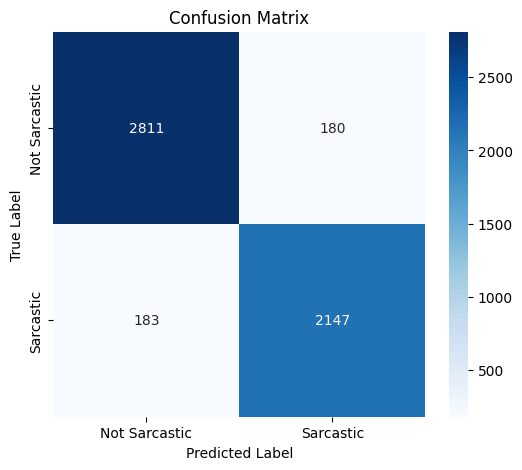

In [12]:
#(10) Compute & Plot Confusion Matrix
def plot_confusion_matrix(trainer, dataset):
    predictions = trainer.predict(dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    labels = predictions.label_ids

    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Sarcastic", "Sarcastic"], yticklabels=["Not Sarcastic", "Sarcastic"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(trainer, test_dataset)

In [13]:
#(11) Save the model
from google.colab import drive

drive.mount('/content/drive')

model_save_path = "/content/drive/My Drive/BERT_Sarcasm_Model"

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"model saved to {model_save_path}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
model saved to /content/drive/My Drive/BERT_Sarcasm_Model
